Who were the survivors of the Titanic catastrophe?

Let's approach this from a data scientist's perspective.

## Data Exploration

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

titanic_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Here's the data.  We're trying to predict whether the passenger survived or not, so that's the output column, or pd.Series, we'll focus on.  All the other columns, or features, are predictors for survival.

In other words, with a classifier, we are basically creating a function $f(X) = y$, where $X$ are the `{passengerId, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked}` features, and $Y$ is the `{Survived [0, 1]}` feature.

Let's take a closer look at our features.

In [83]:
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Right away, we see that not all features are `describe()`ed.  Only features with numbers are.  From `passengerId`, our "primary key", we see that there are 891 entries in our data set.  In addition,  for our `Age` feature, there are only 741 entries.  Let's try and fix that later.

Looking at the data, we see that about 38% of the passengers survived, that the average age was about 29.7, and people paid about 32.2 pounds for the fare (which is skewed to by the +75% percentile).  We can better visualize this by:

Let's take a look at the `python3` data types.

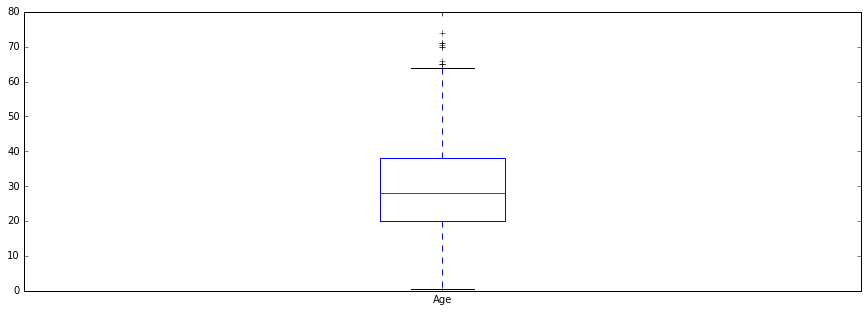

In [84]:
titanic_df['Age'].plot.box()

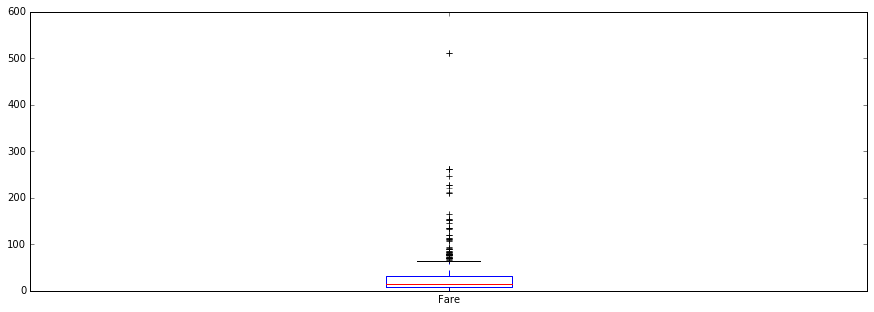

In [85]:
titanic_df['Fare'].plot.box()

Those are box plots of our two numerical features.  The other features with numbers corresponds to categorical features, or boolean features.

Let's take a look 

In [86]:
titanic_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

I'm assuming that the `object` data types represent Strings.  They usually do.  We might want to convert certain String features, like `Sex`, into numbers if our classification algorithm can be improved by doing so (it usually can, if the data adds value).  Again, let's worry about that later.

## Data Munging, Cleaning

#### Filling in missing values for 'Age'
Let's first take a look at the different ages in our data set.


In [87]:
titanic_df['Age'].unique()

array([ 22.  ,  38.  ,  26.  ,  35.  ,    nan,  54.  ,   2.  ,  27.  ,
        14.  ,   4.  ,  58.  ,  20.  ,  39.  ,  55.  ,  31.  ,  34.  ,
        15.  ,  28.  ,   8.  ,  19.  ,  40.  ,  66.  ,  42.  ,  21.  ,
        18.  ,   3.  ,   7.  ,  49.  ,  29.  ,  65.  ,  28.5 ,   5.  ,
        11.  ,  45.  ,  17.  ,  32.  ,  16.  ,  25.  ,   0.83,  30.  ,
        33.  ,  23.  ,  24.  ,  46.  ,  59.  ,  71.  ,  37.  ,  47.  ,
        14.5 ,  70.5 ,  32.5 ,  12.  ,   9.  ,  36.5 ,  51.  ,  55.5 ,
        40.5 ,  44.  ,   1.  ,  61.  ,  56.  ,  50.  ,  36.  ,  45.5 ,
        20.5 ,  62.  ,  41.  ,  52.  ,  63.  ,  23.5 ,   0.92,  43.  ,
        60.  ,  10.  ,  64.  ,  13.  ,  48.  ,   0.75,  53.  ,  57.  ,
        80.  ,  70.  ,  24.5 ,   6.  ,   0.67,  30.5 ,   0.42,  34.5 ,  74.  ])

If we want to use certain classifiers for the `Age` feature, we'll need to fill in that `nan` value.  The usual options are:

- Throw away the rows, or [entry, sample] without the feature.  We lose the most data that way, especially if the sample is mostly filled out.
- Fill in the data with a guess.
  - The simplest way is to fill it with a measure of central tendency: the mean, median, or mode.
    - We typically use the median, since it isn't affected by outliers.  Look how for the fare, the highest prices skewed the average towards 32 pounds, but at the 50th percentile, the price was only 14 pounds.
  - More complicated methods include creating a predictor for the guess based on the features we do have.  Like, based on the name, gender, and fare, we guess that this person is of this age.  Basically, we could create a regression to fill in the missing data.
  
We'll go with filling the data with the median.

In [88]:
titanic_df['Age'] = titanic['Age'].fillna(titanic['Age'].median())

print(titanic_df['Age'].median())
print(titanic_df['Age'].dtype)
titanic_df['Age'].unique()

28.0
float64


array([ 22.  ,  38.  ,  26.  ,  35.  ,  28.  ,  54.  ,   2.  ,  27.  ,
        14.  ,   4.  ,  58.  ,  20.  ,  39.  ,  55.  ,  31.  ,  34.  ,
        15.  ,   8.  ,  19.  ,  40.  ,  66.  ,  42.  ,  21.  ,  18.  ,
         3.  ,   7.  ,  49.  ,  29.  ,  65.  ,  28.5 ,   5.  ,  11.  ,
        45.  ,  17.  ,  32.  ,  16.  ,  25.  ,   0.83,  30.  ,  33.  ,
        23.  ,  24.  ,  46.  ,  59.  ,  71.  ,  37.  ,  47.  ,  14.5 ,
        70.5 ,  32.5 ,  12.  ,   9.  ,  36.5 ,  51.  ,  55.5 ,  40.5 ,
        44.  ,   1.  ,  61.  ,  56.  ,  50.  ,  36.  ,  45.5 ,  20.5 ,
        62.  ,  41.  ,  52.  ,  63.  ,  23.5 ,   0.92,  43.  ,  60.  ,
        10.  ,  64.  ,  13.  ,  48.  ,   0.75,  53.  ,  57.  ,  80.  ,
        70.  ,  24.5 ,   6.  ,   0.67,  30.5 ,   0.42,  34.5 ,  74.  ])

We'll see that the `nan` value is gone, and the data type of our feature is `float64`, which is a number our classifiers can use.

### Converting Strings to numbers
Why do we only convert sex and embarked?

#### Converting the 'Sex' feature

In [89]:
titanic_df['Sex'].unique()

array(['male', 'female'], dtype=object)

In [94]:
titanic_df.loc[titanic['Sex'] == 'female', 'Sex'] = 0
titanic_df.loc[titanic['Sex'] == 'male', 'Sex'] = 1

print(titanic_df['Sex'].unique())
print(titanic_df['Sex'].describe())

[1 0]
count     891
unique      2
top         1
freq      577
Name: Sex, dtype: int64


#### Converting the 'Embarked' feature

In [91]:
print('Embarked feature:\n', titanic_df['Embarked'].describe(), '\n')
print('Uniques: ', titanic_df['Embarked'].unique())

Embarked feature:
 count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object 

Uniques:  ['S' 'C' 'Q' nan]


We see the there are empty most frequent value is `S`, 

In [92]:
titanic_df['Embarked'] = titanic_df['Embarked'].fillna('S')


titanic_df.loc[titanic_df['Embarked'] == 'S', 'Embarked'] = 0
titanic_df.loc[titanic_df['Embarked'] == 'C', 'Embarked'] = 1
titanic_df.loc[titanic_df['Embarked'] == 'Q', 'Embarked'] = 2

print("resulant uniques : ", titanic['Embarked'].unique())

resulant uniques :  [0 1 2]


## Modeling

In [97]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold

predictors = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
alg = LinearRegression()

kf = KFold(titanic_df.shape[0], n_folds=3, random_state=1)
predictions = []
for train, test, in kf:
    train_predictors = (titanic_df[predictors].iloc[train, :])
    train_target = titanic_df['Survived'].iloc[train]
    
    alg.fit(train_predictors, train_target)
    
    test_predictions = alg.predict(titanic_df[predictors].iloc[test, :])
    predictions.append(test_predictions)

print(predictions)

[array([  8.99877810e-02,   9.60756206e-01,   5.92676278e-01,
         9.31138728e-01,   5.29343071e-02,   1.70275685e-01,
         3.69943590e-01,   1.03474847e-01,   5.21597906e-01,
         8.74491050e-01,   6.48883611e-01,   8.29742769e-01,
         1.34797198e-01,  -1.61126844e-01,   6.58141307e-01,
         6.39819748e-01,   1.51733875e-01,   2.95432718e-01,
         5.35377959e-01,   6.21007683e-01,   2.61872592e-01,
         2.62687561e-01,   7.31739160e-01,   5.05995897e-01,
         5.61398567e-01,   3.35039734e-01,   1.30338808e-01,
         4.68765767e-01,   6.60737753e-01,   9.10819218e-02,
         4.77223920e-01,   1.04220026e+00,   6.60691613e-01,
         8.71539273e-02,   5.28550732e-01,   4.01874338e-01,
         1.30340307e-01,   1.29339672e-01,   5.72717129e-01,
         6.65238822e-01,   4.83215779e-01,   7.60807408e-01,
         1.30578363e-01,   8.71867121e-01,   7.09855487e-01,
         9.11369897e-02,   1.39181745e-01,   6.60691613e-01,
         6.82833485e-02